Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.3172 - loss: 3.5321 - precision_3: 0.2517 - recall_3: 0.0053 - val_accuracy: 0.4185 - val_loss: 1.4130 - val_precision_3: 0.5753 - val_recall_3: 0.1930 - learning_rate: 0.0010
Epoch 2/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4433 - loss: 1.2597 - precision_3: 0.5484 - recall_3: 0.2141 - val_accuracy: 0.5625 - val_loss: 1.1428 - val_precision_3: 0.7266 - val_recall_3: 0.3760 - learning_rate: 0.0010
Epoch 3/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6452 - loss: 0.9242 - precision_3: 0.7971 - recall_3: 0.4886 - val_accuracy: 0.7050 - val_loss: 0.8932 - val_precision_3: 0.8953 - val_recall_3: 0.5385 - learning_rate: 0.0010
Epoch 4/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.7788 - loss: 0.6493 - precision_3: 0.8770 - recall_3: 0.6623 - val_accuracy: 0.7505 - val_loss: 0.8323 - val_precision_3: 0.8204 - val_recall_3: 0.6785 - learning_rate: 0.0010
Epoch 5/12
125/125 ━━━━━━━━━━━━━━━━━━━

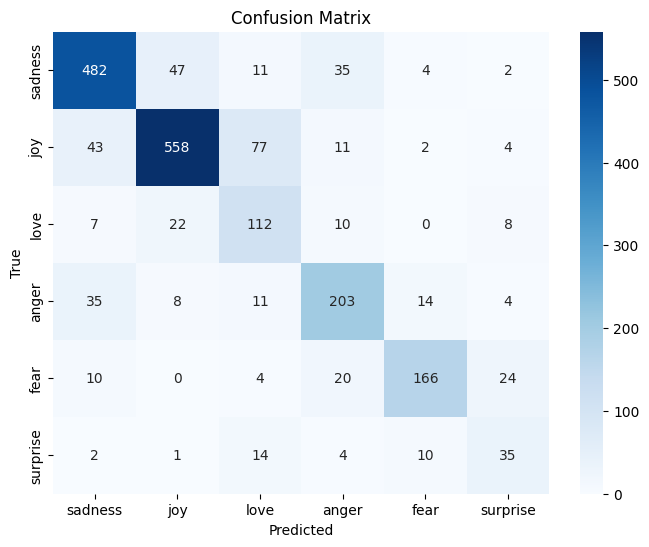

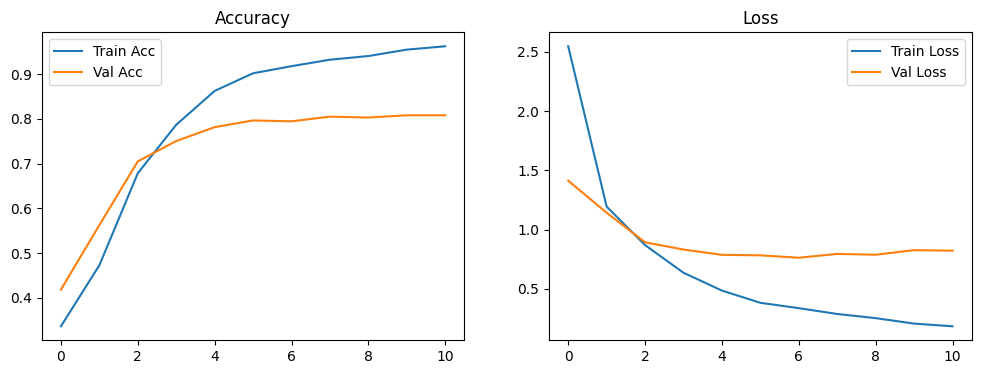

In [4]:
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

splits = {
    'train': 'split/train-00000-of-00001.parquet',
    'validation': 'split/validation-00000-of-00001.parquet',
    'test': 'split/test-00000-of-00001.parquet'
}

train_df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
val_df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
test_df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def build_vocab(texts, batch_size=1000, n_process=1):
    all_tokens = []
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        all_tokens.extend(tokens)
    vocab = {token: idx + 1 for idx, token in enumerate(sorted(set(all_tokens)))}
    return vocab

def preprocess_and_pad(texts, vocab, batch_size=1000, n_process=1, pad_length=10):
    sequences = []
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        token_ids = [vocab.get(token, 0) for token in tokens]
        if len(token_ids) < pad_length:
            token_ids += [0] * (pad_length - len(token_ids))
        else:
            token_ids = token_ids[:pad_length]
        sequences.append(token_ids)
    return sequences

MAX_LEN = 10

# Build vocab from all texts
all_texts = train_df['text'].tolist() + val_df['text'].tolist() + test_df['text'].tolist()
vocab = build_vocab(all_texts)
VOCAB_SIZE = len(vocab) + 1

# Preprocess texts
X_train = np.array(preprocess_and_pad(train_df['text'].tolist(), vocab, pad_length=MAX_LEN))
X_val = np.array(preprocess_and_pad(val_df['text'].tolist(), vocab, pad_length=MAX_LEN))
X_test = np.array(preprocess_and_pad(test_df['text'].tolist(), vocab, pad_length=MAX_LEN))

# One-hot encode labels
num_classes = len(emotion_labels)
y_train = to_categorical(train_df['label'], num_classes=num_classes)
y_val = to_categorical(val_df['label'], num_classes=num_classes)
y_test = to_categorical(test_df['label'], num_classes=num_classes)

# Model definition (lightweight)
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_LEN, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_dropout=0.1)),
   
    Bidirectional(LSTM(64)),

    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
loss, acc, prec, rec = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy/Loss plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Save model and vocab
model.save("best_emotion_model.h5")  

# Save vocab separately
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)


In [11]:
import joblib

bundle = {
    "model_path": "best_emotion_model.h5",  
    "vocab": vocab                  
}

joblib.dump(bundle, "model_bundle.pkl")


['model_bundle.pkl']